In [1]:
import os
import pandas as pd
import subprocess
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
import string
import matplotlib.gridspec as gridspec
import geopandas as gpd
import cartopy.crs as ccrs
import numpy as np
import pycoda
from matplotlib.patches import Patch

sns.set_context('paper')
FIG_PATH = '/Users/hanmar/OneDrive - Danmarks Tekniske Universitet/PhD/manuscripts/db_paper/figures'
DATA_PATH = '../data/'
alphabet = list(string.ascii_lowercase)

def query_db(cmd):
    p = subprocess.run(f"mysql -e \"{cmd}\"", shell=True, stderr=subprocess.PIPE, stdout=subprocess.PIPE)
    return  pd.read_csv(StringIO(p.stdout.decode()), sep='\t')

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

In [2]:
def figure_saver(fig, prefix, contexts=['paper'], formats=['.png', '.pdf', '.tiff']):
    
    for context in contexts:
        
        for fformat in formats:
            fname = f"{prefix}_{context}{fformat}"
            fig.savefig(fname)
    
    sns.set_context('paper')

def get_cmap(labels, name='viridis'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    cmap = plt.get_cmap(name, len(labels))#.colors
    
    return {l: cmap(i) for i, l in enumerate(labels)}


In [4]:
# retrieve metadata
pull = False
metadataFile = os.path.join(DATA_PATH, 'metadata.h5')
if pull:
    metadata = query_db(
        "select run_accession, host, IF( (collection_date <= '2020-01-01') AND (collection_date >= '1800-01-01'), YEAR(collection_date), NULL)  as year , CONCAT(IF(SPLIT_STRING(location, ' ', 2) LIKE 'S', '-', ''), SPLIT_STRING(location, ' ', 1)) as latitude, CONCAT(IF(SPLIT_STRING(location, ' ', 4) LIKE 'W', '-', ''), SPLIT_STRING(location, ' ', 3)) as longitude, raw_reads, trimmed_fragments, instrument_platform, country, continent from Meta_public inner join run_overview using(run_accession, sample_accession, project_accession) where mapped_ResFinder=1 and mapped_Silva=1"
    )
    
    metadata.to_hdf(metadataFile, key='metadata')
else:
    metadata = pd.read_hdf(metadataFile, key='metadata')

/Users/hanmar/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/core/generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['run_accession', 'host', 'instrument_platform', 'country', 'continent'], dtype='object')]

  pytables.to_hdf(


In [5]:
continent_order = ['Africa', 'Antarctica', 'Asia', 'Europe', 'North America', 'Oceania', 'South America', 'Arctic Ocean', 'Atlantic Ocean', 'Indian Ocean', 'Norwegian Sea', 'Pacific Ocean', 'Red Sea']

hostCounts = metadata.groupby('host').agg({'run_accession': 'count', 'trimmed_fragments': 'sum'}).sort_values(by='run_accession')
host1k = hostCounts.query("run_accession >= 1000").index
host_index = host1k.str.lower().argsort()
host_order = host1k[host_index]
host_axlabels = [" ".join([h.split(' ')[0].title()] + h.split(' ')[1:]) for h in host1k]

# Figure 1

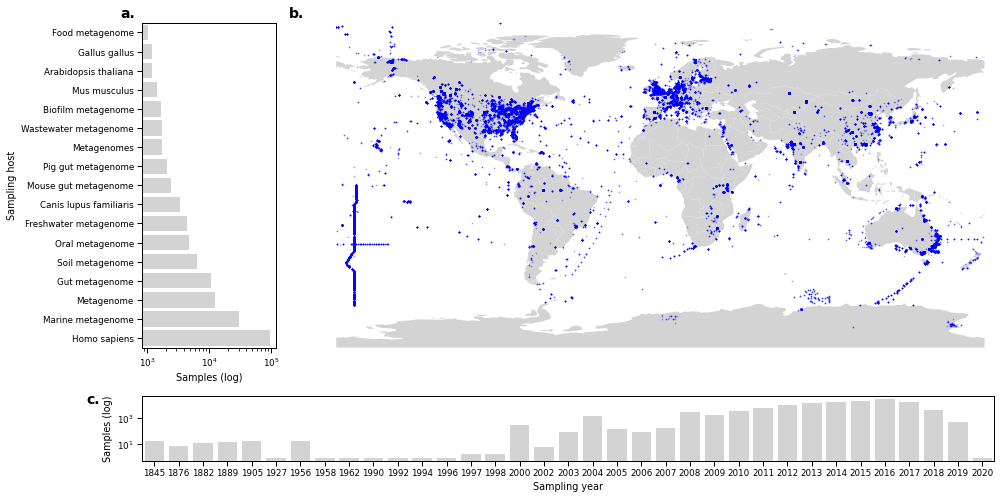

In [9]:
fig = plt.figure(figsize=(14,7))

gs = gridspec.GridSpec(ncols=2, nrows=2, height_ratios=[1, .2], width_ratios=[.2, 1])


ax_map = fig.add_subplot(gs[0, 1])
ax_host = fig.add_subplot(gs[0, 0])
#ax_host_b = fig.add_subplot(gs[0, 1], sharey=ax_host)
ax_time = fig.add_subplot(gs[-1, :])

sns.barplot(data=hostCounts.loc[hostCounts.run_accession >= 1000].reset_index(), x='run_accession', y='host', orient='h', ax=ax_host, color='lightgrey') 
ax_host.set_xscale('log')
ax_host.set_xlabel('Samples (log)')
ax_host.set_ylabel('Sampling host')
ax_host.set_yticklabels(host_axlabels)

#sns.barplot(data=hostCounts.loc[hostCounts.run_accession >= 1000].reset_index(), x='trimmed_fragments', y='host', orient='h', ax=ax_host_b, color='grey') 
#ax_host_b.set_xscale('log')
#ax_host_b.set_xlabel('Fragments (log)')
#

# map
world.plot(ax=ax_map, color="lightgrey")
metadata.plot(x="longitude", y="latitude", ax=ax_map, kind="scatter", color="blue", alpha=.25, s=1)
ax_map.axis('off')
ax_map.set_xlabel('Sampling location')
ax_map.margins(0)
ax_map.apply_aspect()

# year
timeCounts = metadata.groupby('year').agg({'run_accession': 'count', 'trimmed_fragments': 'sum'}).sort_values(by='run_accession').reset_index()
timeCounts['year'] = timeCounts['year'].astype('int')

sns.barplot(
    data=timeCounts.reset_index(),
    x='year',
    y = 'run_accession',
    ax=ax_time,
    color='lightgrey'
)
ax_time.set_yscale('log')
ax_time.set_xlabel('Sampling year')
ax_time.set_ylabel('Samples (log)')


for ax, label in zip([ax_host, ax_map, ax_time], alphabet):
    ax.text(-0.05, 1.05, label + '.', transform=ax.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')

fig.tight_layout()

figure_saver(fig=fig, prefix=os.path.join(FIG_PATH, 'sample_origins'), contexts=['paper', 'talk'])

# save data
hostCounts.to_csv(os.path.join(DATA_PATH, 'figure-data', 'fig1A_host_data.csv'))
metadata[['run_accession', 'longitude', 'latitude']].to_csv(os.path.join(DATA_PATH, 'figure-data', 'fig1B_loc_data.csv'))
timeCounts.to_csv(os.path.join(DATA_PATH, 'figure-data', 'fig1C_year_data.csv'))

# Figure S1

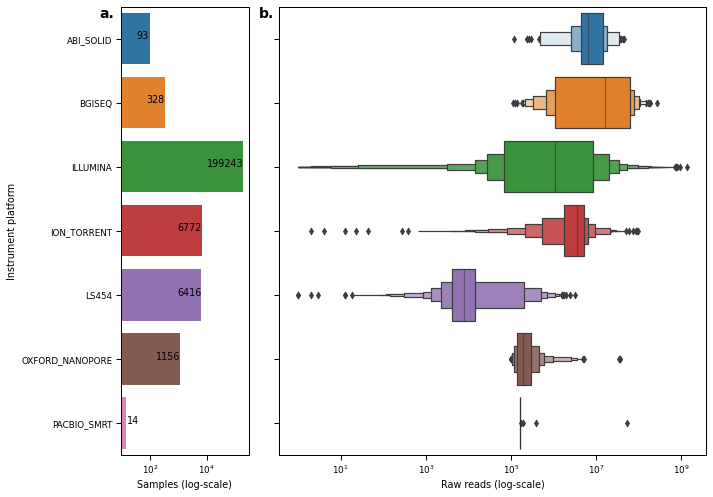

In [10]:
fig, axes = plt.subplots(1,2, figsize=(10,7), sharey=True, gridspec_kw={'width_ratios': [.3, 1]})

readPlatformSum = metadata.groupby('instrument_platform').agg({'run_accession': 'count'}).reset_index().sort_values(by='instrument_platform')
sns.barplot(
    data = readPlatformSum,
    y = 'instrument_platform',
    x = 'run_accession',
    orient='h',
    ax=axes[0]
)
axes[0].set_xscale('log')

for index, row in readPlatformSum.iterrows():
    if row.run_accession > 20:
        axes[0].text(row.run_accession-10, index, row.run_accession, color='black', ha="right")
    else:
        axes[0].text(row.run_accession, index, row.run_accession, color='black', ha="left")



sns.boxenplot(
    data=metadata.sort_values(by='instrument_platform'),
    x='raw_reads',
    y='instrument_platform',
    ax=axes[1],
    orient='h'
),
axes[1].set_xscale('log')

# labels
axes[0].set_ylabel("Instrument platform")
axes[1].set_ylabel('')

axes[0].set_xlabel("Samples (log-scale)")
axes[1].set_xlabel("Raw reads (log-scale)")

axes[0].text(-0.05, 1, 'a.', transform=axes[0].transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
axes[1].text(-0.01, 1, 'b.', transform=axes[1].transAxes, fontsize=14, va='top', ha='right', fontweight='bold')

fig.tight_layout()
figure_saver(fig=fig, prefix=os.path.join(FIG_PATH, 'platform_overview'))

# save data
readPlatformSum.to_csv(os.path.join(DATA_PATH, 'figure-data', 'figS1A_platform_count_data.csv'))
metadata[['run_accession', 'instrument_platform', 'raw_reads']].to_csv(os.path.join(DATA_PATH, 'figure-data', 'figS1B_platform_frag_data.csv'))


# Figure S2

In [12]:
found_stats = query_db(
    "select ResFinder_anno.anno_value as ResFinder_class, count(gene) as Total, sum(IF(gene in (SELECT distinct(refSequence) from AVA_public), 1, 0)) as Found, count(gene) - sum(IF(gene in (SELECT distinct(refSequence) from AVA_public), 1, 0))  as Missing from ResFinder_anno where anno_type='Class' group by anno_value"
)
found_total = query_db(
    "CREATE TEMPORARY TABLE gene_found AS (select gene, IF(gene in (SELECT distinct(refSequence) from AVA_public), 'Found', 'Missing') as found from ResFinder_anno where anno_type='Class'); select found, count(distinct(gene)) as gcount from gene_found group by found"
)

n = found_stats.shape[0]
found_stats.loc[n, ['ResFinder_class', 'Found', 'Missing', 'Total']] = ['All'] + found_total.set_index('found').T.values.tolist()[0] + [sum(found_total.set_index('found').T.values.tolist()[0])]
for c in ['Missing', 'Found', 'Total']:
    found_stats[c] = found_stats[c].astype('int')

found_stats['label'] = found_stats.apply(lambda x: f"{x['ResFinder_class']} ({x['Found']}/{x['Total']})", axis=1, result_type='expand')


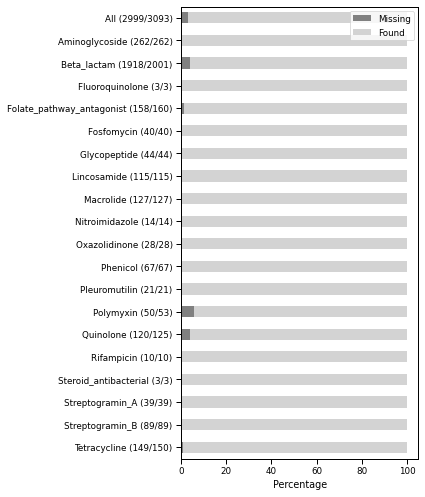

In [13]:
fig, ax = plt.subplots(figsize=(6,7))
found_stats.set_index('label')[['Missing', 'Found']].sort_index(ascending=False).coda.closure(100).plot.barh(stacked=True, color=['grey', 'lightgray'], ax=ax)
ax.legend(loc='upper right')
ax.set_ylabel('')
ax.set_xlabel('Percentage')
fig.tight_layout()
figure_saver(fig=fig, prefix=os.path.join(FIG_PATH, 'ResFinder_found'), contexts=['paper', 'talk'])

# save data
found_stats.to_csv(os.path.join(DATA_PATH, 'figure-data', 'figS2_found-missing_data.csv'))


# Figure 2

In [15]:
pull = True
fragDataFile = os.path.join(DATA_PATH, 'fragData.h5')

if pull:
    fragData=query_db("select run_accession, category, total_fragments, category_fragments from Diversity")
    fragData.to_hdf(fragDataFile, key='fragData')

else:
    fragData = pd.read_hdf(fragDataFile, key='fragData')

In [16]:
# summary statistics for how many fragments could be mapped
print(
    fragData.drop_duplicates(subset=['run_accession', 'total_fragments'])['total_fragments'].describe(), 
    fragData.drop_duplicates(subset=['run_accession', 'total_fragments'])['total_fragments'].sum(), 
    sep='\n'
)

count    2.132560e+05
mean     7.927448e+06
std      2.150121e+07
min      1.000000e+00
25%      5.570600e+04
50%      7.847480e+05
75%      6.711620e+06
max      9.169014e+08
Name: total_fragments, dtype: float64
1690575810608


In [17]:
# mapping percentages
(fragData.groupby('category').agg({'category_fragments': 'sum', 'total_fragments': 'sum'})  / 1690575810608)*100

,category_fragments,total_fragments
category,,
ARG,0.043015,97.130376
Genera,0.191964,99.844671
Phyla,0.191964,99.844671


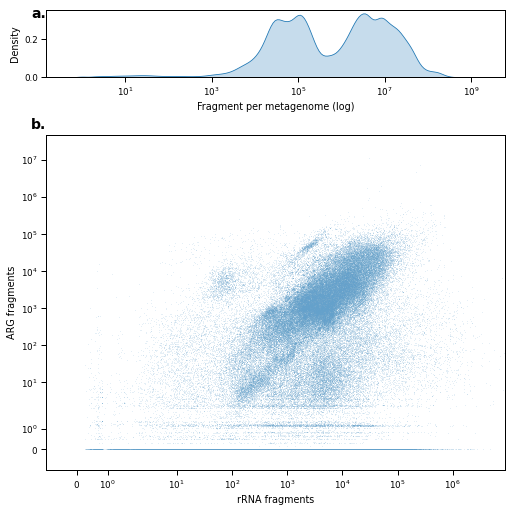

In [18]:
fig = plt.figure(figsize=(7,7), constrained_layout=True)
spec = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[.2,  1])

ax_density = fig.add_subplot(spec[0, 0])
ax_scatter = fig.add_subplot(spec[1, 0])

sns.kdeplot(
    data=fragData.drop_duplicates(subset=['run_accession', 'total_fragments']),
    x='total_fragments',
    fill=True,
    ax=ax_density,
    log_scale=True
)
ax_density.set_xlabel("Fragment per metagenome (log)")

sns.scatterplot(
    data=fragData.pivot_table(index='run_accession', columns='category', values='category_fragments').dropna(subset=['Phyla']).fillna(0),
    x='Phyla',
    y='ARG',
    alpha=.15,
    ax=ax_scatter,
    s=4,
    marker='.'
)

ax_scatter.set_xscale('symlog')
ax_scatter.set_yscale('symlog')

ax_scatter.set_xlim(-1, ax_scatter.get_xlim()[1])
ax_scatter.set_ylim(-1, ax_scatter.get_ylim()[1])

ax_scatter.set_xlabel('rRNA fragments')
ax_scatter.set_ylabel('ARG fragments')

for ax, label in zip([ax_density, ax_scatter], alphabet):
    ax.text(-0.0, 1.05, label + '.', transform=ax.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')


figure_saver(fig=fig, prefix=os.path.join(FIG_PATH, 'overview_fragments_scatter'), contexts=['paper', 'talk'])

# save data
fragData.to_csv(os.path.join(DATA_PATH, 'figure-data', 'fig2AB_fragments_data.csv'))

# Figure S3

In [29]:
selected_hosts = {
    'Homo sapiens': 'Homo sapiens',
    'marine metagenome': 'marine metagenome',
    'soil metagenome': 'soil metagenome',
    'freshwater metagenome': 'freshwater metagenome',
    'wastewater metagenome': 'wastewater metagenome',
    'Canis lupus familiaris': 'Canis lupus familiaris',
    'pig gut metagenome': 'Sus scrofa',
    'Sus scrofa': 'Sus scrofa',
    'Sus scrofa domesticus': 'Sus scrofa',
    'pig metagenome': 'Sus scrofa',
    'chicken gut metagenome': 'Gallus gallus',
    'Gallus gallus': 'Gallus gallus',
    'cow dung metagenome': 'Bos taurus',
    'Bos taurus': 'Bos taurus',
    'mouse metagenome': 'Mus musculus',
    'mouse gut metagenome': 'Mus musculus',
    'Mus musculus': 'Mus musculus',
    
}

t = fragData.pivot_table(index=['run_accession', 'total_fragments'], columns='category', values='category_fragments').fillna(0).reset_index().merge(metadata, on='run_accession')
t = t.query("Phyla > 0")
t['selected_host'] = t['host'].map(selected_hosts)


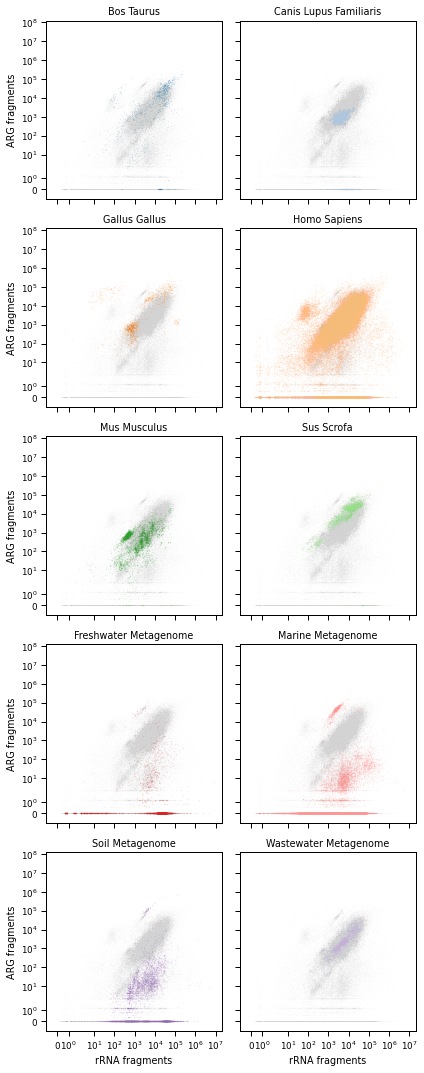

In [30]:
fig, axes = plt.subplots(5, 2, figsize=(3*2, 3*5), sharex=True, sharey=True)


colors = list(sns.palettes.color_palette('tab20').as_hex())
colors.pop(14)
colors.pop(14)


for ax, h, c, letter in zip(axes.flatten(), sorted(set(selected_hosts.values())), colors, alphabet):
    
    td = t.loc[t.selected_host == h]
    tn = t.loc[t.selected_host != h]
    
    ax.scatter(
        x = tn['Phyla'],
        y=tn['ARG'],
        color='lightgray',
        alpha = .05,
        marker='.',
        s=.1
    )
    
    ax.scatter(
        x = td['Phyla'],
        y=td['ARG'],
        color=c,
        alpha = .1,
        marker='.',
        s=1
    )
    
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ax.set_xlim(-1, ax.get_xlim()[1])
    ax.set_ylim(-1, ax.get_ylim()[1])
    ax.set_title(h.title())
    



for ax in axes[:, 0].flatten():
    ax.set_ylabel('ARG fragments')

for ax in axes[-1, :].flatten():
    ax.set_xlabel('rRNA fragments')

fig.tight_layout()
figure_saver(fig=fig, prefix=os.path.join(FIG_PATH, 'overview_fragments_host'), contexts=['paper', 'talk'])

# Figure 3

In [20]:
pull = True
classAMRfile = os.path.join(DATA_PATH, 'classAMR.h5')
if pull: 
    classAMRdf = query_db("select run_accession, bacterial_fragment, anno_value as ResFinder_class, sum(fragmentCountAln/(refSequence_length / 1e3)) as fragmentCountAln from AVA_public right join ResFinder_anno on refSequence=gene where anno_type='Class' group by run_accession, bacterial_fragment, anno_value")
    classAMRdf = classAMRdf.merge(metadata, on='run_accession', how='left')
    classAMRdf.replace(['Missing', 'Not available'], np.nan, inplace=True)
    
    classAMRdf.to_hdf(classAMRfile, key='classAMR')
else:
    classAMRdf = pd.read_hdf(classAMRfile, key='classAMR')

/Users/hanmar/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/core/generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['run_accession', 'ResFinder_class', 'host', 'instrument_platform',
       'country', 'continent'],
      dtype='object')]

  pytables.to_hdf(


In [21]:
ARGabundances = classAMRdf.replace(['Missing', 'Not available'], np.nan).groupby(
    ['run_accession', 'year', 'continent', 'host']
).agg(
    {'bacterial_fragment': 'max', 'fragmentCountAln': 'sum'}
).apply(lambda x: np.log(x['fragmentCountAln'] / (x['bacterial_fragment'] / 1e6)), axis=1).replace([np.inf, -np.inf], np.nan).dropna()

<ipython-input-21-e7deea0d47fb>:5: RuntimeWarning: divide by zero encountered in double_scalars
  ).apply(lambda x: np.log(x['fragmentCountAln'] / (x['bacterial_fragment'] / 1e6)), axis=1).replace([np.inf, -np.inf], np.nan).dropna()
<ipython-input-21-e7deea0d47fb>:5: RuntimeWarning: divide by zero encountered in log
  ).apply(lambda x: np.log(x['fragmentCountAln'] / (x['bacterial_fragment'] / 1e6)), axis=1).replace([np.inf, -np.inf], np.nan).dropna()


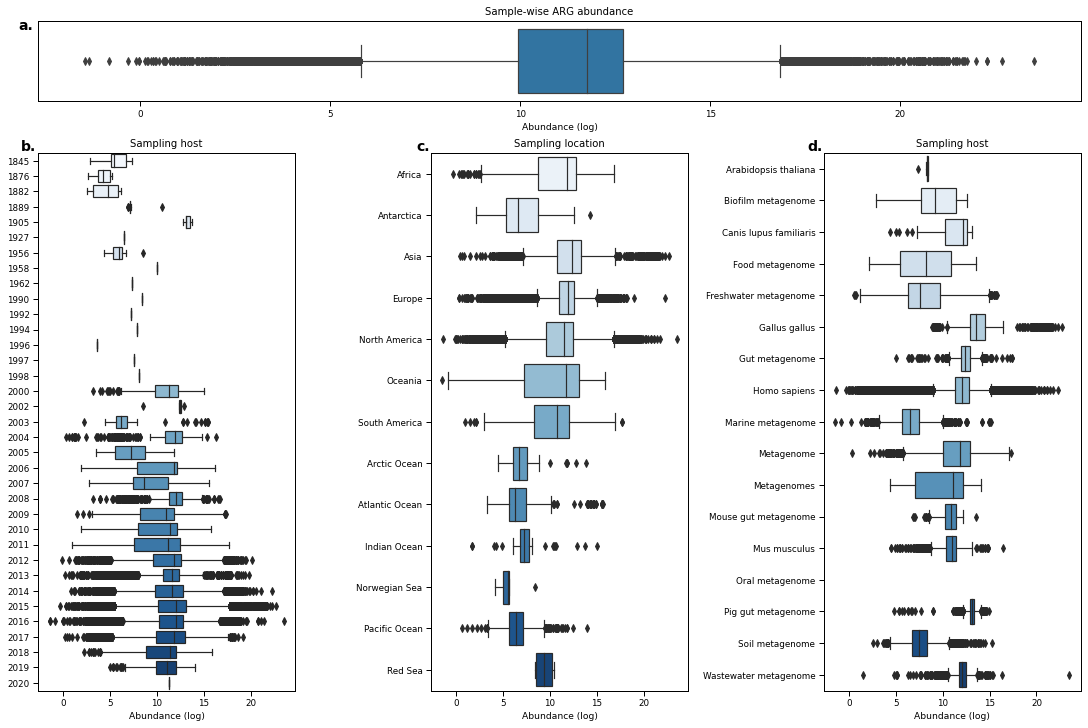

In [22]:
fig = plt.figure(figsize=(15,10), constrained_layout=True)
spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig, height_ratios=[.15, 1], hspace=.02)

ax_bar = fig.add_subplot(spec[0,:])
ax_year = fig.add_subplot(spec[1,0])
ax_continent = fig.add_subplot(spec[1,1])
ax_host = fig.add_subplot(spec[1, 2])

sns.boxplot(data=ARGabundances.dropna(), orient='h', ax=ax_bar)#, scale='count')
ax_bar.set_xlabel('Abundance (log)')
ax_bar.set_yticks(ticks=[])
ax_bar.set_title("Sample-wise ARG abundance")

sns.boxplot(data=ARGabundances.reset_index(level=1), x=0, y='year', ax=ax_year, orient='h', palette="Blues")
sns.boxplot(data=ARGabundances.reset_index(level=2).sort_values(by='continent'), x=0, y='continent', ax=ax_continent, orient='h', color="lightgrey", palette="Blues", order=continent_order)
sns.boxplot(data=ARGabundances.loc[ARGabundances.index.get_level_values('host').isin(host1k),].reset_index(level=3).sort_values(by='host'), x=0, y='host', ax=ax_host, orient='h', palette="Blues", order=host_order)

ax_host.set_yticklabels([host_axlabels[i] for i in host_index])
ax_year.set_yticklabels([t.get_text().replace('.0', '') for t in ax_year.get_yticklabels()])

for ax, t, label in zip([ax_bar, ax_year, ax_continent, ax_host], ['Sample-wise ARG abundance','Sampling host', 'Sampling location', 'Sampling host'], alphabet):
    ax.set_xlabel('Abundance (log)', fontsize=plt.rcParams['axes.labelsize']-.5)
    ax.set_ylabel('')
    ax.set_title(t, fontsize=plt.rcParams['axes.titlesize']+.5)
    ax.text(-0.005, 1.025, label + '.', transform=ax.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')

figure_saver(fig=fig, prefix=os.path.join(FIG_PATH, 'ARG_abundances'), contexts=['paper', 'talk'])

# save data
ARGabundances.to_csv(os.path.join(DATA_PATH, 'figure-data', 'fig3_ARG_abundances_data.csv'))

# Figure 4

In [23]:
ResFinder_classes = sorted(classAMRdf.ResFinder_class.dropna().unique())
AMR_colors = get_cmap(ResFinder_classes, 'tab20')

continentRel = classAMRdf.groupby(['continent', 'ResFinder_class']).agg({'fragmentCountAln': 'sum'}).reset_index().pivot('continent', 'ResFinder_class', 'fragmentCountAln').fillna(0).coda.closure(1)
yearRel = classAMRdf.groupby(['year', 'ResFinder_class']).agg({'fragmentCountAln': 'sum'}).reset_index().pivot('year', 'ResFinder_class', 'fragmentCountAln').fillna(0).coda.closure(1)
hostRel = classAMRdf.groupby(['host', 'ResFinder_class']).agg({'fragmentCountAln': 'sum'}).reset_index().pivot('host', 'ResFinder_class', 'fragmentCountAln').fillna(0).coda.closure(1)

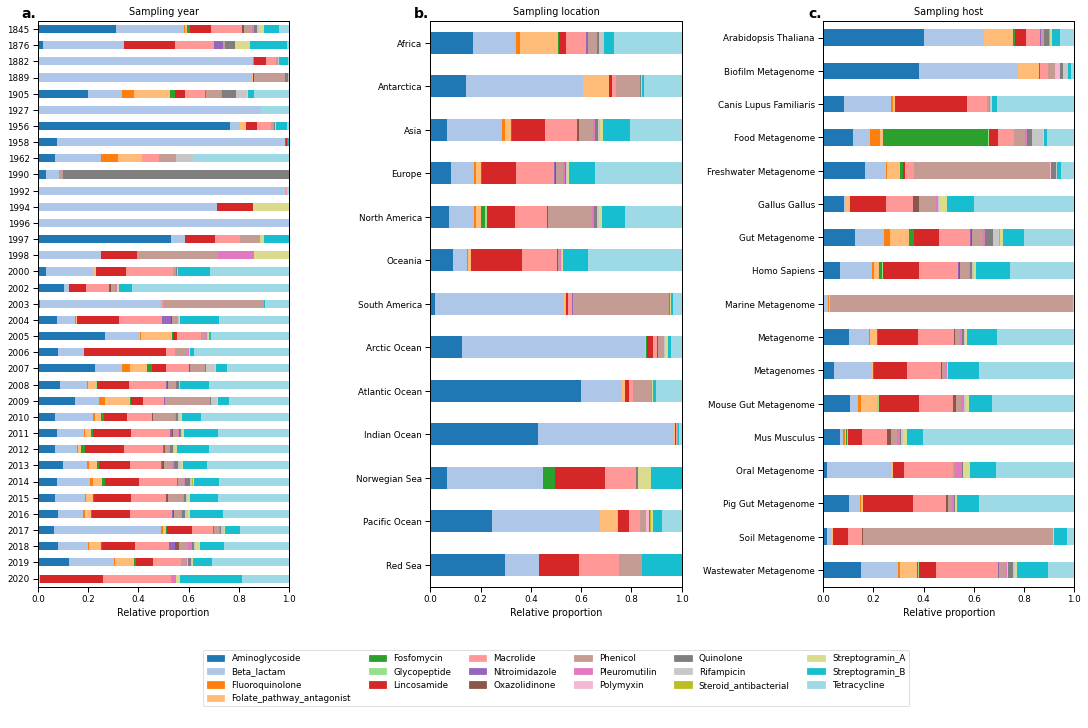

In [24]:
fig = plt.figure(figsize=(15,10), constrained_layout=True)
spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig, height_ratios=[1, .15], hspace=.05)

ax_year = fig.add_subplot(spec[0,0])
ax_continent = fig.add_subplot(spec[0,1])
ax_host = fig.add_subplot(spec[0, 2])
ax_leg = fig.add_subplot(spec[1,:])

xlabel = 'Relative proportion'

yearRel.sort_index(ascending=False).plot.barh(stacked=True, color=AMR_colors, ax=ax_year, legend=False)
ax_year.set_xlabel(xlabel)
ax_year.set_ylabel('')
ax_year.set_title("Sampling year")
ax_year.set_xlim(0,1)
ax_year.set_yticklabels([t.get_text().replace('.0', '') for t in ax_year.get_yticklabels()])

continentRel.loc[continent_order].loc[::-1].plot.barh(stacked=True, color=AMR_colors, ax=ax_continent, legend=False, sort_columns=False)
ax_continent.set_xlabel(xlabel)
ax_continent.set_ylabel('')
ax_continent.set_title("Sampling location")
ax_continent.set_xlim(0,1)

hostRel.loc[host_order[::-1]].plot.barh(stacked=True, color=AMR_colors, ax=ax_host, legend=False)
ax_host.set_xlabel(xlabel)
ax_host.set_ylabel('')
ax_host.set_title("Sampling host")
ax_host.set_xlim(0, 1)
ax_host.set_yticklabels([t.get_text().title() for t in ax_host.get_yticklabels()])

for ax, label in zip([ax_year, ax_continent, ax_host], alphabet):
    ax.text(-0.005, 1.025, label + '.', transform=ax.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')

handles = [Patch(facecolor=v, edgecolor=v, label=k) for k, v in AMR_colors.items()]
ax_leg.legend(handles=handles, ncol=6, loc="center")
ax_leg.axis('off')
figure_saver(fig=fig, prefix=os.path.join(FIG_PATH, 'ARG_distribution'), contexts=['paper', 'talk'])

# save data
yearRel.to_csv(os.path.join(DATA_PATH, 'figure-data', 'fig4A_year_relARG_data.csv'))
continentRel.to_csv(os.path.join(DATA_PATH, 'figure-data', 'fig4B_contintent_relARG_data.csv'))
hostRel.to_csv(os.path.join(DATA_PATH, 'figure-data', 'fig4C_host_relARG_data.csv'))

# Figure S4

In [27]:
pull = True

diversityFile = os.path.join(DATA_PATH, 'classAMR.h5')
if pull:
    divtest = query_db("select run_accession, kma_version, category, n, Shannon, IF(Simpson<0, NULL, Simpson) as Simpson from Diversity;")
    div = divtest.pivot_table(index='run_accession', columns=['category'], values=['n', 'Shannon', 'Simpson'])
    
    div.to_hdf(diversityFile, key='diversity')
else:
    div = pd.read_hdf(diversityFile, key='diversity')

In [ ]:
shannondiv = div['Shannon'].merge(metadata, left_index=True, right_on='run_accession', how='left')
shannondiv['selected_host'] = shannondiv['host'].map(selected_hosts)

ndiv = div['n'].merge(metadata, left_index=True, right_on='run_accession', how='left')
ndiv['selected_host'] = ndiv['host'].map(selected_hosts)

fig = plt.figure(figsize=(5 + (4*2), 7*2))

spec = gridspec.GridSpec(ncols=5, nrows=5*2, figure=fig, wspace=0.1, hspace=0.9, width_ratios=[1, 1, 0.01, 0.5, 0.5])


ax_main_n = fig.add_subplot(spec[:5, :2])
sns.scatterplot(
    data = ndiv,
    x = 'Genera',
    y = 'ARG',
    s = 6,
    alpha = .2,
    ax = ax_main_n
)
ax_main_n.set_xscale('symlog')
ax_main_n.set_yscale('symlog')

ax_main_n.set_xlim(0, ax_main_n.get_xlim()[1])
ax_main_n.set_ylim(0, ax_main_n.get_ylim()[1])

ax_main_n.set_xlabel('')
ax_main_n.set_ylabel('ARG')

specs = [(i, j) for i in range(5) for j in range(3, 5)]
for i, (s, h, c, letter) in enumerate(zip(specs, sorted(set(selected_hosts.values())), colors, alphabet)):
    ax = fig.add_subplot(spec[s[0], s[1]])    
    sns.scatterplot(
        data = ndiv.loc[ndiv.selected_host != h],
        x = 'Genera',
        y = 'ARG',
        s = 1,
        alpha = .1,
        ax = ax,
        color='lightgray'
    )
      
    sns.scatterplot(
        data = ndiv.loc[ndiv.selected_host == h],
        x = 'Genera',
        y = 'ARG',
        s = 4,
        alpha = .2,
        ax = ax,
        color=c
    )
    
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ax.set_xlim(0, ax.get_xlim()[1])
    ax.set_ylim(0, ax.get_ylim()[1])
    
    ax.set_title(h.title())
    
    if  i < 8: 
        ax.set_xticklabels([])
    ax.set_xlabel('')

        
    if (i+1) % 2 == 0:
        ax.set_yticklabels([])
    ax.set_ylabel('')


ax_main_shannon = fig.add_subplot(spec[-5:, :2])
sns.scatterplot(
    data = shannondiv,
    x = 'Genera',
    y = 'ARG',
    s = 6,
    alpha = .2,
    ax = ax_main_shannon
)


ax_main_shannon.set_xlabel('Genera')
ax_main_shannon.set_ylabel('ARG')

specs = [(i, j) for i in range(5, 10) for j in range(3, 5)]
sub_axes = []
for i, (s, h, c, letter) in enumerate(zip(specs, sorted(set(selected_hosts.values())), colors, alphabet)):
    ax = fig.add_subplot(spec[s[0], s[1]])    
    sns.scatterplot(
        data = shannondiv.loc[shannondiv.selected_host != h],
        x = 'Genera',
        y = 'ARG',
        s = 1,
        alpha = .1,
        ax = ax,
        color='lightgray'
    )
      
    sns.scatterplot(
        data = shannondiv.loc[shannondiv.selected_host == h],
        x = 'Genera',
        y = 'ARG',
        s = 4,
        alpha = .2,
        ax = ax,
        color=c
    )
    
    ax.set_title(h.title())
    
    if  i < 8: 
        ax.set_xticklabels([])
    ax.set_xlabel('')

        
    if (i+1) % 2 == 0:
        ax.set_yticklabels([])
    ax.set_ylabel('')

ax_main_n.text(-0.005, 1.025, 'a.', transform=ax_main_n.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
ax_main_n.set_title('Observed richness', fontsize=14)
ax_main_shannon.text(-0.005, 1.025, 'b.', transform=ax_main_shannon.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
ax_main_shannon.set_title('Shannon diversity', fontsize=14)

figure_saver(fig=fig, prefix=os.path.join(FIG_PATH, 'overview_richness_shannon_host'), contexts=['paper', 'talk'])

# save data
ndiv.to_csv(os.path.join(DATA_PATH, 'figure-data', 'figS4A_observed_richness_data.csv'))
shannondiv.to_csv(os.path.join(DATA_PATH, 'figure-data', 'figS4B_shannon_div_data.csv'))


# Figure 5

In [ ]:
simpsondiv = div['Simpson'].merge(metadata, left_index=True, right_on='run_accession', how='left')
simpsondiv['selected_host'] = simpsondiv['host'].map(selected_hosts)

fig = plt.figure(figsize=(5 + (4*2), 7))

spec = gridspec.GridSpec(ncols=5, nrows=5, figure=fig, wspace=0.1, hspace=0.4, width_ratios=[1, 1, 0.01, 0.5, 0.5])

ax_main = fig.add_subplot(spec[:, :2])
sns.scatterplot(
    data = simpsondiv,
    x = 'Genera',
    y = 'ARG',
    s = 6,
    alpha = .2,
    ax = ax_main
)


ax_main.set_xlabel('Genera Gini-Simpson')
ax_main.set_ylabel('ARG Gini-Simpson')

specs = [(i, j) for i in range(5) for j in range(3, 5)]
sub_axes = []
for i, (s, h, c, letter) in enumerate(zip(specs, sorted(set(selected_hosts.values())), colors, alphabet)):
    ax = fig.add_subplot(spec[s[0], s[1]])    
    sns.scatterplot(
        data = simpsondiv.loc[simpsondiv.selected_host != h],
        x = 'Genera',
        y = 'ARG',
        s = 1,
        alpha = .1,
        ax = ax,
        color='lightgray'
    )
      
    sns.scatterplot(
        data = simpsondiv.loc[simpsondiv.selected_host == h],
        x = 'Genera',
        y = 'ARG',
        s = 4,
        alpha = .2,
        ax = ax,
        color=c
    )
    
    ax.set_title(h.title())
    
    if  i < 8: 
        ax.set_xticklabels([])
    ax.set_xlabel('')

        
    if (i+1) % 2 == 0:
        ax.set_yticklabels([])
    ax.set_ylabel('')
figure_saver(fig=fig, prefix=os.path.join(FIG_PATH, 'overview_simpson_host'), contexts=['paper', 'talk'])

# save data
simpsondiv.to_csv(os.path.join(DATA_PATH, 'figure-data', 'fig5_simpson_div_data.csv'))
